In [1]:
from collections import defaultdict
from itertools import combinations
import math
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px      
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import re as regular_expressions
from scipy.stats import norm, pearsonr, spearmanr
from sklearn.metrics import accuracy_score
import spacy
from spacy.cli import download
from spacy.util import is_package
import statsmodels.api as sm
from statsmodels.stats.multitest import multipletests
from statsmodels.stats.weightstats import ttest_ind
from statsmodels.stats.inter_rater import cohens_kappa, to_table
import statsmodels.formula.api as smf
import textwrap

# Example Frames from Each Video
<table>
  <tr>
    <td align="center">Video&nbsp;1<br>
      <img src="img/vid1-prev.png" width="200">
    </td>
    <td align="center">Video&nbsp;2<br>
      <img src="img/vid2-prev.png" width="200">
    </td>
    <td align="center">Video&nbsp;3<br>
      <img src="img/vid3-prev.png" width="200">
    </td>
  </tr>
  <tr>
    <td align="center">Video&nbsp;4<br>
      <img src="img/vid4-prev.png" width="200">
    </td>
    <td align="center">Video&nbsp;5<br>
      <img src="img/vid5-prev.png" width="200">
    </td>
    <td align="center">Video&nbsp;6<br>
      <img src="img/vid6-prev.png" width="200">
    </td>
  </tr>
  <tr>
    <td align="center">Video&nbsp;7<br>
      <img src="img/vid7-prev.png" width="200">
    </td>
    <td align="center">Video&nbsp;8<br>
      <img src="img/vid8-prev.png" width="200">
    </td>
    <td align="center">Video&nbsp;9<br>
      <img src="img/vid9-prev.png" width="200">
    </td>
  </tr>
  <tr>
    <td align="center">Video&nbsp;10<br>
      <img src="img/vid10-prev.png" width="200">
    </td>
    <td align="center">Video&nbsp;11<br>
      <img src="img/vid11-prev.png" width="200">
    </td>
    <td align="center">Video&nbsp;12<br>
      <img src="img/vid12-prev.png" width="200">
    </td>
  </tr>
  <tr>
    <td align="center">Video&nbsp;13<br>
      <img src="img/vid13-prev.png" width="200">
    </td>
    <td align="center">Video&nbsp;14<br>
      <img src="img/vid14-prev.png" width="200">
    </td>
    <td align="center">Video&nbsp;15<br>
      <img src="img/vid15-prev.png" width="200">
    </td>
  </tr>
</table>


# Load Dataset

In [2]:
df_annotated = pd.read_csv(os.path.join(os.getcwd(), 'annotated_dataset.csv'), sep=';', encoding='utf-8')
print("df length:", len(df_annotated))
df_annotated = df_annotated[df_annotated["Group"] != "excluded"]
df_annotated["Subgroup"] = df_annotated["Subgroup"].astype("string")
print("df length after removing excluded questions:", len(df_annotated))
df_annotated.head(1)


df length: 1893
df length after removing excluded questions: 1893


,Stimulus,Q_ID,Question,Q_Importance,Participant_ID,Group,Subgroup,Participant_Robot_Experience,Participant_Avg_Attitudes_S,Participant_Average_Attitudes_P
0,Vid1,Q1,What salad were you making?,4.0,p1,execution-details,what-goal,7,4.6,3.4


# Inter Annotator Agreement

In [3]:
# load df_for_IAA.csv
df_IAA = pd.read_csv("df_for_IAA.csv", sep=";")
# compute IAA between row "Group" and row "Annotator-1"

# drop missing labels — statsmodels' helpers don't handle NaNs
raw = df_IAA[["Group (Annotator-1)", "Annotator-2"]].dropna().to_numpy()

# build the contingency table for the two raters
table, _ = to_table(raw)  # shape: (n_classes, n_classes)

res = cohens_kappa(table)              # returns KappaResults
print(res)                

iaa_accuracy = accuracy_score(df_IAA["Group (Annotator-1)"], df_IAA["Annotator-2"])
print(f"Accuracy IAA: {iaa_accuracy:.3f}")

# print all instances where the two annotators disagree
disagreements = df_IAA[df_IAA["Group (Annotator-1)"] != df_IAA["Annotator-2"]]
print("Disagreements:")
disagreements

                  Simple Kappa Coefficient
              --------------------------------
              Kappa                     0.7727
              ASE                       0.0451
              95% Lower Conf Limit      0.6843
              95% Upper Conf Limit      0.8611

                 Test of H0: Simple Kappa = 0

              ASE under H0              0.0307
              Z                         25.1943
              One-sided Pr >  Z         0.0000
              Two-sided Pr > |Z|        0.0000

Accuracy IAA: 0.792
Disagreements:


,Stimulus,Q_ID,Question,Q_Importance,Participant_ID,Group (Annotator-1),Subgroup,Annotator-2
7,Vid1,Q4,Don't we need salad dressing?,3.0,R_2ROLkn5dyU92blU,mental-state,check-understanding/beliefs,self/task-assessment
14,vid10,Q3,What factors do you take into consideration wh...,4.0,R_2dvdoUcNnhE1r5z,how-did-you-decide,steps-to-take,technical-details
18,vid14,Q1,When you cracked the eggs how were you certain...,4.0,R_9znWIqnU8C5fz2Z,potential-issues,how-to-ensure-correctness,how-did-you-know
25,vid6,Q2,If it can remember where it placed each item?,2.0,R_8pXG43dM8nxtLHE,execution-details,what-location,what-abilities
34,vid6,Q3,Do you have any suggestion on how to better or...,2.0,R_2k5QSlY95Vtirfk,mental-state,ideas,future-actions
35,Vid4,Q2,how do you check that there is no bacteria on ...,4.0,R_21iQ9oF5M9bzjeg,potential-issues,how-to-ensure-correctness,technical-details
41,vid8,Q1,Why does it seem so struggle with certain piec...,2.0,R_3aS0gNZse7DMWkl,why,why-issues,technical-details
47,vid15,Q3,Where is the recipe from that you are following?,3.0,R_2Nn2gYl9AxN0IcY,execution-details,goal-origin,environment-state
51,vid12,Q1,Do you wait a specific amount of time for the ...,4.0,R_5kgIcvzbXW6bmit,how-did-you-know,goal-achieved,technical-details
53,vid11,Q2,How many times a day do you feed the cat?,5.0,R_21zSRo6v5goC908,time,frequency,execution-details


# Participant Statistics


In [4]:
df_participants = pd.read_csv(os.path.join(os.getcwd(), 'raw_results.csv'), sep=';', encoding='utf-8')
print("df lengths (= #participants):", len(df_participants))
df_participants.head(1)

df lengths (= #participants): 100


,Participant_ID,Vid1-Q1,Vid1-Q1-Imp,Vid1-Q2,Vid1-Q2-Imp,Vid1-Q3,Vid1-Q3-Imp,Vid1-Q4,Vid1-Q4-Imp,Vid2-Q1,...,AttitudesP3,AttitudesP4,AttitudesP5,AttitudesS1,AttitudesS2,AttitudesS3,AttitudesS4,AttitudesS5,AttitudesAvgP,AttitudesAvgS
0,p1,What salad were you making?,4.0,What ingredients did you put in the salad and ...,4.0,What other salads can you make?,3.0,Do you need help with anything?,3.0,How did you pick the lunchbox items?,...,3,5,3,5,4,4,6,4,3.4,4.6


Demographic Details

In [5]:
# value counts of columns "StudySubject", "RobotProgramming", "InteractionExp", "RobotExpScale"

# "Ethnicity", "Country", "Gender", "Age" removed for public version

demographic_cols = [
    "StudySubject", "RobotProgramming", "InteractionExp", "RobotExpScale", "AttitudesAvgP", "AttitudesAvgS"
]

for col in demographic_cols:
    print(df_participants[col].value_counts().sort_index())
    print("-" * 50)

StudySubject
No     79
Yes    21
Name: count, dtype: int64
--------------------------------------------------
RobotProgramming
No     96
Yes     4
Name: count, dtype: int64
--------------------------------------------------
InteractionExp
No     67
Yes    33
Name: count, dtype: int64
--------------------------------------------------
RobotExpScale
1    40
2    15
3    21
4    10
5     9
6     3
7     2
Name: count, dtype: int64
--------------------------------------------------
AttitudesAvgP
1.8     2
2.2     1
2.4     2
2.6     1
2.8     3
3.0     3
3.2     1
3.4     6
3.6     1
3.8     6
4.0     6
4.2     8
4.4    10
4.6     6
4.8     7
5.0     5
5.2     2
5.4     6
5.6     7
5.8     1
6.0     3
6.2     8
6.6     2
6.8     1
7.0     2
Name: count, dtype: int64
--------------------------------------------------
AttitudesAvgS
2.8     1
3.2     1
4.0     2
4.2     3
4.4     3
4.6    10
4.8     4
5.0     6
5.2     6
5.4     3
5.6    14
5.8     4
6.0     5
6.2    10
6.4     5
6.6    10
6.

In [6]:
# Plotly collage of participant attributes from df_participants 

numeric_cols = ["RobotExpScale", "AttitudesAvgP", "AttitudesAvgS"]
categorical_cols = ["RobotProgramming", "InteractionExp", "StudySubject"]

# Pretty display names 
pretty_names = {
    "RobotProgramming": "Robot Programming Exp.",
    "InteractionExp": "Robot Interaction Exp.",
    "RobotExpScale": "Experience w. Robots",
    "AttitudesAvgP": "Attitudes towards Robots (Personal)",
    "AttitudesAvgS": "Attitudes (Societal)",
    "StudySubject": "Studied CS/Eng.",
}

axis_names = {
    "RobotProgramming": "Score",
    "InteractionExp": "Score",
    "RobotExpScale": "Score",
    "AttitudesAvgP": "Score",
    "AttitudesAvgS": "Score",
    "StudySubject": "Studied CS/Eng.",
}

# ---- Tunable aesthetics/logic ----
COLS_PER_ROW = 5
FIG_WIDTH = 1200
ROW_HEIGHT = 240  
FONT_FAMILY = "Times New Roman"  
TITLE_SIZE = 16
AXIS_SIZE = 14
TICK_SIZE = 16
BARGAP = 0.25

# For very busy categoricals, keep Top-N and collapse the rest into "Other"
TOP_N = {"CountryText": 15, "StudySubject": 15}
MISSING_LABEL = "Missing"

BIN_AGE = True
AGE_BIN_WIDTH = 5  # years


available_numeric = [c for c in numeric_cols if c in df_participants.columns]
available_categorical = [c for c in categorical_cols if c in df_participants.columns]
all_cols = available_numeric + available_categorical
assert len(all_cols) > 0, "None of the specified columns are present in df_participants."

# ---- Helpers ----
def counts_numeric(series: pd.Series):
    s = pd.to_numeric(series, errors="coerce").dropna()
    if series.name == "Age" and BIN_AGE and s.nunique() > 20:
        lo, hi = int(np.floor(s.min())), int(np.ceil(s.max()))
        bins = np.arange(lo, hi + AGE_BIN_WIDTH, AGE_BIN_WIDTH)
        binned = pd.cut(s, bins=bins, right=False)
        counts = binned.value_counts().sort_index()
        labels = [f"{int(iv.left)}–{int(iv.right-1)}" for iv in counts.index]  # [18–22] style
        vals = counts.values
        return labels, vals
    # discrete integers
    s = s.astype(int)
    vc = s.value_counts().sort_index()
    return vc.index.astype(str).tolist(), vc.values

def counts_categorical(series: pd.Series, top_n: int | None = None):
    s = series.fillna(MISSING_LABEL).astype(str).str.strip()
    vc = s.value_counts()
    if top_n is not None and len(vc) > top_n:
        top = vc.iloc[: top_n - 1]
        other = pd.Series({"Other": vc.iloc[top_n - 1 :].sum()})
        vc = pd.concat([top, other])
    # For horizontal bar with largest at top, sort ascending (smallest bottom, largest top)
    vc = vc.sort_values(ascending=True)
    return vc.index.tolist(), vc.values

def add_bar_numeric(fig, row, col, name, x_labels, y_vals):
    total = np.sum(y_vals) if len(y_vals) else 0
    perc = (100 * y_vals / total) if total else np.zeros_like(y_vals)
    fig.add_trace(
        go.Bar(
            x=x_labels,
            y=y_vals,
            text=None, # [f"{v} ({p:.1f}%)" for v, p in zip(y_vals, perc)],
            textposition="outside",
            hovertemplate="<b>%{x}</b><br>Count: %{y}<br>% of shown: %{text}<extra></extra>",
            showlegend=False,
        ),
        row=row, col=col,
    )
    fig.update_xaxes(title_text=axis_names.get(name, name), row=row, col=col, tickangle=-45 if len(x_labels) > 10 else 0)
    fig.update_yaxes(title_text="Count", row=row, col=col)

def add_bar_categorical(fig, row, col, name, y_labels, x_vals):
    total = np.sum(x_vals) if len(x_vals) else 0
    perc = (100 * x_vals / total) if total else np.zeros_like(x_vals)
    fig.add_trace(
        go.Bar(
            x=x_vals,
            y=y_labels,
            orientation="h",
            text=None,# [f"{v} ({p:.1f}%)" for v, p in zip(x_vals, perc)],
            textposition="outside",
            hovertemplate="<b>%{y}</b><br>Count: %{x}<br>% of shown: %{text}<extra></extra>",
            showlegend=False,
        ),
        row=row, col=col,
    )
    fig.update_xaxes(title_text="Count", row=row, col=col)

# ---- Build subplot grid ----
n_plots = len(all_cols)
rows = math.ceil(n_plots / COLS_PER_ROW)

fig = make_subplots(
    rows=rows,
    cols=COLS_PER_ROW,
    subplot_titles=[pretty_names.get(c, c) for c in all_cols],
    horizontal_spacing=0.1,
    vertical_spacing=0.30,
)

# ---- Add traces ----
i = 0
for col in all_cols:
    r = i // COLS_PER_ROW + 1
    c = i % COLS_PER_ROW + 1
    if col in available_numeric:
        x_labels, y_vals = counts_numeric(df_participants[col])
        add_bar_numeric(fig, r, c, col, x_labels, y_vals)
    else:
        top_n = TOP_N.get(col)  # None unless configured above
        y_labels, x_vals = counts_categorical(df_participants[col], top_n=top_n)
        add_bar_categorical(fig, r, c, col, y_labels, x_vals)
    i += 1

# ---- Layout ----
fig.update_layout(
    template="plotly_white",
    height=rows * ROW_HEIGHT,
    width=FIG_WIDTH,
    bargap=BARGAP,
    font=dict(family=FONT_FAMILY, size=AXIS_SIZE),
    margin=dict(l=60, r=60, t=60, b=40),
)
fig.update_annotations(yshift=10)
for ann in fig.layout.annotations:
    ann.font.size = TITLE_SIZE

fig.show()

# save as pdf
fig.write_image(
    os.path.join(os.getcwd(), "plots/user_distribution.pdf"),
    width=FIG_WIDTH,
    height=rows * ROW_HEIGHT,
)


# RQ1: Question Categories

Three category visualizations that help with understanding the distribution of question types in the dataset
- a sunburst chart
- a treemap
- a sankey diagram

In [7]:
# Sunburst Representation
# replace every flavour of "empty" with one placeholder
df_annotated["Subgroup"] = df_annotated["Subgroup"].replace(
    {"": "Other",         
     "nan":  "Other",       
     None: "Other"}         
)

df_annotated = df_annotated.dropna(subset=['Group'])


df_annotated[["Group", "Subgroup"]] = (
    df_annotated[["Group", "Subgroup"]]
      .apply(lambda col: col.str.split(",")
                           .apply(lambda lst: [x.strip() for x in lst] 
                                             if isinstance(lst, list) else lst))
)
df_annotated = df_annotated.explode(["Group", "Subgroup"], ignore_index=True)

fig = px.sunburst(
    df_annotated,                               
    path=["Group", "Subgroup"],        
    values=None                       
)
fig.update_traces(
    textinfo="label+value",                 
    texttemplate="%{label}<br>%{value}",    
    insidetextorientation="radial"          
)
fig.update_layout(
    margin=dict(t=0, l=0, r=0, b=0),    
    width=800,
    height=800
)
fig.show()

In [8]:
# compare the distribution of the "group" column for text plans vs text vids
df_annotated_text_plans = df_annotated[df_annotated['Stimulus'].str.contains('plan', case=False)]
df_annotated_text_vids = df_annotated[df_annotated['Stimulus'].str.contains('vid', case=False)]

df_group_plans = df_annotated_text_plans['Group'].value_counts(normalize=True)
df_group_vids = df_annotated_text_vids['Group'].value_counts(normalize=True)

for group in df_group_plans.index:
    print(f"Plan {group}: {df_group_plans[group]:.2f}")
print()
for group in df_group_vids.index:
    print(f"Vid {group}: {df_group_vids[group]:.2f}")

Plan execution-details: 0.35
Plan time: 0.10
Plan self/task-assessment: 0.10
Plan why: 0.08
Plan environment-state: 0.08
Plan how-did-you-decide: 0.07
Plan future-actions: 0.06
Plan potential-issues: 0.05
Plan what-abilities: 0.04
Plan how-did-you-know: 0.04
Plan mental-state: 0.03
Plan technical-details: 0.02

Vid what-abilities: 0.17
Vid execution-details: 0.15
Vid self/task-assessment: 0.11
Vid why: 0.11
Vid environment-state: 0.08
Vid how-did-you-know: 0.08
Vid mental-state: 0.08
Vid potential-issues: 0.07
Vid time: 0.05
Vid how-did-you-decide: 0.04
Vid future-actions: 0.03
Vid technical-details: 0.03


In [9]:
# Treemap representation, colored by importance

# for every subgroup with less than 5 entries, replace the subgroup with "Other"
THRESH = 5

tot = df_annotated["Q_Importance"].sum()
grp_pct = (df_annotated.groupby("Group")["Q_Importance"].sum() / tot)

df_annotated_temp = df_annotated.copy()
df_annotated_temp["Group_label"] = df_annotated["Group"].map(
    lambda g: f"{g} ({grp_pct[g]:.1%})"
)

df_annotated_temp['n'] = (
    df_annotated_temp
        .groupby(['Group', 'Subgroup'])
        .transform('size')
)
df_annotated_temp['Subgroup_collapsed'] = np.where(df_annotated_temp['n'] < THRESH, "Other", df_annotated_temp['Subgroup'])
fig = px.treemap(
    df_annotated_temp,
    path=["Group_label", "Subgroup_collapsed"],
    color ="Q_Importance",  # color by importance
    color_continuous_scale="mint",
    values=None,
)
fig.update_coloraxes(
    colorbar=dict(
        title="Importance",
        tickmode="array",
        tickvals=[1, 2, 3, 4, 5],
        ticktext=[
            "1 (not at all important)",
            "2",
            "3 (moderately important)",
            "4 (very important)",
            "5 (extremely important)"
        ]
    )
)
fig.update_layout(
    margin=dict(t=0, l=0, r=0, b=0),
    width=800,
    height=800
)
fig.update_traces(
    marker=dict(cornerradius=5),
    textinfo="label+value",
    texttemplate="%{label}<br>%{value}",
)
fig.show()
# save as pdf 
fig.write_image(os.path.join(os.getcwd(), 'plots/question_category_analysis.pdf'), width=900, height=1200)


In [10]:
# Sankey Diagram of Groups → Subgroups


THRESH = 15                 # collapse subgroups with < THRESH rows into "Other – <Group>"
USE_IMPORTANCE = False       # True => weight flows by sum of Q_Importance; False => by counts
WRAP_WIDTH_GROUP = 50       # character wrap width for group labels
WRAP_WIDTH_SUB = 50         # character wrap width for subgroup labels
MERGE_SUBGROUPS_GLOBALLY = False  # if True, same Subgroup name across Groups becomes one node
FIG_W, FIG_H = 2000, 2400    # sankey canvas size


def wrap_label(s, width=16):
    return "<br>".join(textwrap.wrap(str(s), width=width))

def hex_to_rgb(hex_color):
    hex_color = hex_color.lstrip("#")
    return tuple(int(hex_color[i:i+2], 16) for i in (0, 2, 4))

def rgba_str(rgb, a=1.0):
    r, g, b = rgb
    return f"rgba({r},{g},{b},{a})"

# ------------------------------------------------------------
# DATA PREP (assumes df_annotated with columns: Group, Subgroup, Q_Importance)
# ------------------------------------------------------------
df = df_annotated.copy()

# collapse tiny subgroups within each (Group, Subgroup)
df["n"] = df.groupby(["Group", "Subgroup"])["Subgroup"].transform("size")
df["Subgroup_collapsed"] = np.where(df["n"] < THRESH, "other", df["Subgroup"])

agg = (
    df.groupby(["Group", "Subgroup_collapsed"])["Q_Importance" if USE_IMPORTANCE else "Subgroup"].count()
    .reset_index(name="value")
)
total_value = float(agg["value"].sum())
group_totals = agg.groupby("Group")["value"].sum().to_dict()

groups = sorted(agg["Group"].unique(),
                key=lambda g: group_totals.get(g, 0.0),
                reverse=True)
group_labels = [
    f"<span style='font-size:32px'>{wrap_label(g, WRAP_WIDTH_GROUP)}</span><br>({group_totals[g] / total_value:.1%})"
    for g in groups
]
if MERGE_SUBGROUPS_GLOBALLY:
    agg["SubNode"] = agg["Subgroup_collapsed"]
else:
    # disambiguate subgroups per group to avoid unintended merging
    agg["SubNode"] = agg.apply(
        lambda r: f"{r['Subgroup_collapsed']} — {r['Group']}", axis=1
    )

subnodes_order = []
for g in groups:
    subs_in_group = agg.loc[agg["Group"] == g, "SubNode"].unique()
    # optional: sort by subgroup value
    subs_in_group = sorted(
        subs_in_group,
        key=lambda s: agg.loc[agg["SubNode"] == s, "value"].sum(),
        reverse=True
    )
    subnodes_order.extend(subs_in_group)

def pretty_sub_label(subnode, subcount):
    if " — " in subnode and not MERGE_SUBGROUPS_GLOBALLY:
        sub, g = subnode.split(" — ", 1)
    else:
        sub, g = subnode, None

    if g is not None:
        return f"{wrap_label(sub, WRAP_WIDTH_SUB)} ({subcount})<br><span style='opacity:0.0'>{wrap_label(g, WRAP_WIDTH_GROUP)}</span>"
    else:
        return wrap_label(sub, WRAP_WIDTH_SUB)

subnode_labels = [pretty_sub_label(s, agg.loc[agg["SubNode"] == s, "value"].sum()) for s in subnodes_order]

# final label list and index lookup
labels = group_labels + subnode_labels
label_to_index = {lab: i for i, lab in enumerate(labels)}
# maps for raw->display label
group_to_display = dict(zip(groups, group_labels))
subnode_to_display = dict(zip(subnodes_order, subnode_labels))

palette = px.colors.qualitative.Plotly  # or "D3", "Set3", etc.
group_colors_hex = {g: palette[i % len(palette)] for i, g in enumerate(groups)}
group_colors_rgb = {g: hex_to_rgb(c) if c.startswith("#") else hex_to_rgb(px.colors.label_rgb(c)) 
                    if isinstance(c, str) and c.startswith("rgb") == False else (31, 119, 180)
                    for g, c in group_colors_hex.items()}
# node colors (groups solid; subnodes = lighter tint of their group's color)
node_colors = []
for g in groups:
    node_colors.append(rgba_str(group_colors_rgb[g], 1.0))  # group node (left)

for s in subnodes_order:
    # get the group this subnode belongs to (when MERGE_SUBGROUPS_GLOBALLY, tint by the largest contributing group)
    if MERGE_SUBGROUPS_GLOBALLY:
        # find the group with the max value contributing to this subnode
        contrib = agg[agg["SubNode"] == s]
        top_g = contrib.sort_values("value", ascending=False).iloc[0]["Group"]
        rgb = group_colors_rgb[top_g]
    else:
        # subnode is unique to its group, parse it
        _sub, g = s.split(" — ", 1) if " — " in s else (s, groups[0])
        rgb = group_colors_rgb[g]
    node_colors.append(rgba_str(rgb, 0.25))  # light tint

sources, targets, values = [], [], []
link_colors, link_customdata = [], []


for _, row in agg.iterrows():
    g = row["Group"]
    s = row["SubNode"]
    val = float(row["value"])

    src_idx = label_to_index[group_to_display[g]]
    tgt_idx = label_to_index[subnode_to_display[s]]

    sources.append(src_idx)
    targets.append(tgt_idx)
    values.append(val)

    # link color = group's color with alpha
    link_colors.append(rgba_str(group_colors_rgb[g], 0.45))

    # for hover: % of group and % of total
    pct_group = val / group_totals[g] if group_totals[g] else 0.0
    pct_total = val / total_value if total_value else 0.0
    link_customdata.append([g, s, pct_group, pct_total])

# ------------------------------------------------------------
# FIGURE
# ------------------------------------------------------------
fig = go.Figure(data=[
    go.Sankey(
        arrangement="fixed", 
        node=dict(
            pad=35,
            thickness=18,
            line=dict(width=0.5, color="rgba(0,0,0,0.2)"),
            label=labels,
            color=node_colors,
            hovertemplate="<b>%{label}</b><extra></extra>",
        ),
        link=dict(
            source=sources,
            target=targets,
            value=values,
            color=link_colors,
            customdata=link_customdata,
            hovertemplate=(
                "<b>%{customdata[0]} → %{customdata[1]}</b><br>"
                "Value: %{value}<br>"
                "% of group: %{customdata[2]:.1%}<br>"
                "% of total: %{customdata[3]:.1%}<extra></extra>"
            ),
        ),
        valueformat=",", 
    )
])

fig.update_layout(
    title=None,
    font=dict(size=25),
    width=FIG_W,
    height=FIG_H,
    margin=dict(t=20, r=20, b=20, l=20),
)

fig.show()

os.makedirs("plots", exist_ok=True)
fig.write_image(
    os.path.join(os.getcwd(), "plots/question_category_sankey.pdf"),
    width=FIG_W,
    height=FIG_H
)


# RQ2: Question Importance Analysis

In [11]:
# Linear mixed-effects model with random intercepts

y_col        = "Q_Importance"    
category_col = "Group"         
stim_col     = "Stimulus"
part_col     = "Participant_ID"

d = df_annotated.dropna(subset=[y_col, category_col, stim_col, part_col]).copy()

for c in (category_col, stim_col, part_col):
    d[c] = d[c].astype("category")

# Use 0 + C(category) so each fixed-effect coefficient = the mean for that category
formula = f"{y_col} ~ 0 + C({category_col})"

# Random intercepts: participants as groups; stimuli as variance components (quirk of statsmodels)
m = smf.mixedlm(formula, d,
                groups=d[part_col],
                re_formula="1",
                vc_formula={stim_col: f"0 + C({stim_col})"})

# Fit model
try:
    res = m.fit(reml=True, method="lbfgs", maxiter=200)
    print("Fitted with LBFGS optimizer.")
except Exception:
    try:
        res = m.fit(reml=True, method="cg", maxiter=200)
        print("Fitted with CG optimizer.")
    except Exception:
        res = m.fit(reml=True, method="nm", maxiter=400)
        print("Fitted with NM optimizer.")

print(res.summary())

# EMMs per category
def _level_from_param(name: str) -> str:
    m = regular_expressions.search(r"\[(?:T\.)?(.+)\]$", name)
    return m.group(1) if m else name

levels = [_level_from_param(n) for n in res.fe_params.index]
emm = pd.DataFrame({
    category_col: levels,
    "EMM": res.fe_params.values,
    "SE": np.sqrt(np.diag(res.cov_params()))[:len(levels)]
})
z_975 = norm.ppf(0.975)
emm["CI_low"]  = emm["EMM"] - z_975 * emm["SE"]
emm["CI_high"] = emm["EMM"] + z_975 * emm["SE"]
emm["Count"] = d[category_col].value_counts().reindex(levels).values
print("\nEstimated marginal means (per category):")
print(emm.sort_values("EMM"))

# pairwise comparisons (z-tests)
pairs = []
cov = res.cov_params()
for i, j in combinations(range(len(levels)), 2):
    lev_i, lev_j = levels[i], levels[j]
    est_i, est_j = res.fe_params.iloc[i], res.fe_params.iloc[j]
    diff = est_i - est_j
    se = np.sqrt(cov.iloc[i, i] + cov.iloc[j, j] - 2 * cov.iloc[i, j])
    z = diff / se
    p_two_sided = 2 * (1 - norm.cdf(abs(z)))
    pairs.append({
        "contrast": f"{lev_i} - {lev_j}",
        "estimate": diff,
        "SE": se,
        "z": z,
        "p": p_two_sided
    })

# correct for multiple testing with Bonferroni-Holm
pairs_df = pd.DataFrame(pairs)
pairs_df["p_adj"] = multipletests(pairs_df["p"].values, method="holm")[1]
pairs_df["sig_0.05"] = pairs_df["p_adj"] < 0.05
pairs_df["CI_low"]  = pairs_df["estimate"] - z_975 * pairs_df["SE"]
pairs_df["CI_high"] = pairs_df["estimate"] + z_975 * pairs_df["SE"]

print("\nPairwise category comparisons (A - B):")
pairs_df.sort_values("p_adj").head(10)


Fitted with LBFGS optimizer.
                 Mixed Linear Model Regression Results
Model:                  MixedLM     Dependent Variable:     Q_Importance
No. Observations:       1948        Method:                 REML        
No. Groups:             100         Scale:                  0.5569      
Min. group size:        9           Log-Likelihood:         -2419.8598  
Max. group size:        27          Converged:              Yes         
Mean group size:        19.5                                            
------------------------------------------------------------------------
                               Coef. Std.Err.   z    P>|z| [0.025 0.975]
------------------------------------------------------------------------
C(Group)[environment-state]    3.697    0.089 41.332 0.000  3.522  3.872
C(Group)[execution-details]    3.810    0.072 53.272 0.000  3.669  3.950
C(Group)[future-actions]       3.661    0.107 34.288 0.000  3.451  3.870
C(Group)[how-did-you-decide]   3.848    

,contrast,estimate,SE,z,p,p_adj,sig_0.05,CI_low,CI_high
55,potential-issues - why,0.429390,0.097527,4.402792,0.000011,0.000705,True,0.238241,0.620540
45,mental-state - potential-issues,-0.477539,0.109753,-4.351045,0.000014,0.000881,True,-0.692650,-0.262427
38,how-did-you-know - mental-state,0.418431,0.106069,3.944877,0.000080,0.005110,True,0.210539,0.626323
54,potential-issues - what-abilities,0.372369,0.095267,3.908702,0.000093,0.005846,True,0.185650,0.559088
44,how-did-you-know - why,0.370282,0.095585,3.873837,0.000107,0.006642,True,0.182938,0.557627
53,potential-issues - time,0.381452,0.107579,3.545798,0.000391,0.023877,True,0.170602,0.592302
46,mental-state - self/task-assessment,-0.327659,0.096059,-3.411000,0.000647,0.038835,True,-0.515932,-0.139386
43,how-did-you-know - what-abilities,0.313261,0.092597,3.383046,0.000717,0.042295,True,0.131774,0.494749
14,execution-details - mental-state,0.275750,0.086781,3.177551,0.001485,0.086144,False,0.105663,0.445837
59,self/task-assessment - why,0.279510,0.088137,3.171335,0.001517,0.086492,False,0.106766,0.452255


In [12]:
# Plot EMMs with significance brackets and CI bands


def observable_forest_plotly(
    stats_df,
    pairs_df=None,        
    alpha=0.05,
    top_k=None,
    xlabel="Question importance score, 0 (not at all important), 5 (extremely important)",
    x_end=None,            
    n_label_x=1.06,        
    brackets="auto",       
    baseline = False,
):
    """
    Expects stats_df with columns: Group, EMM, CI_low, CI_high, Count

    Optional pairs_df with significance results in either format:
      1) Columns: A, B, p_adj
      2) Columns: contrast, p_adj    (where 'contrast' looks like "GroupA - GroupB")

    Parameters
    ----------
    alpha : float
        Adjusted p-value threshold for drawing significance brackets.
    top_k : int or None
        If provided, only the top_k most significant pairs are drawn.
    x_end : float or None
        If provided, x-axis is capped at this value and brackets are drawn outside (paper coords) when
        brackets="auto". If None, brackets are drawn inside (data coords) and axis range expands to fit.
    brackets : {"auto","paper","data"}
        Where to draw the brackets. "auto" uses "paper" when x_end is set, else "data".
    """

    # ---- copy & derived CI bounds ----
    s = stats_df.copy()
    s = s.sort_values("EMM", ascending=True).reset_index(drop=True)

    # ---- style constants ----
    palette     = ['#ef4444', '#22c55e', '#3b82f6', '#8b5cf6', '#f59e0b', '#06b6d4']
    band_alpha  = 0.22
    band_h      = 0.62
    dot_size    = 14
    xr_base_min = 0.0
    colors = {g: palette[i % len(palette)] for i, g in enumerate(s["Group"])}
    k      = len(s)
    y_pos  = {g: i for i, g in enumerate(s["Group"])}
    x_data_max = float(s["CI_high"].max())
    x_right_base = x_end if x_end is not None else x_data_max
    xr = max(1e-9, x_right_base - xr_base_min)
    right_label_pad   = 0.10 * xr
    right_bracket_pad = 0.08 * xr
    x_max_inside = x_right_base + (0 if x_end is not None else (right_label_pad + right_bracket_pad))

    fig = go.Figure()
    shapes = []
    ann = []

    # ---- rounded-rectangle path for CI pills ----
    def rounded_rect_path(x0, x1, yc, h, r_frac=0.08):
        y0, y1 = yc - h/2, yc + h/2
        r = min((x1-x0)/2, h/2) * r_frac * 2.0
        return (
            f"M {x0+r},{y0} L {x1-r},{y0} "
            f"Q {x1},{y0} {x1},{y0+r} L {x1},{y1-r} "
            f"Q {x1},{y1} {x1-r},{y1} L {x0+r},{y1} "
            f"Q {x0},{y1} {x0},{y1-r} L {x0},{y0+r} "
            f"Q {x0},{y0} {x0+r},{y0} Z"
        )

    # ---- plot rows ----
    for _, row in s.iterrows():
        g   = row["Group"]
        mu  = float(row["EMM"])
        lo  = float(row["CI_low"])
        hi  = float(row["CI_high"])
        n   = int(row["Count"])
        yi  = y_pos[g]
        col = colors[g]

        # rounded CI band 
        shapes.append(dict(
            type="path", path=rounded_rect_path(lo, hi, yi, band_h),
            line=dict(width=0), fillcolor=col, opacity=band_alpha,
            layer="between", xref="x", yref="y"
        ))

        if baseline:
            shapes.append(dict(
                type="line", x0=xr_base_min, x1=mu, y0=yi, y1=yi,
                line=dict(width=12, color=col), opacity=1.0,
                layer="below",
                xref="x",
            yref="y"
            ))

        # mean dot for EMM
        fig.add_trace(go.Scatter(
            x=[mu], y=[yi], mode="markers",
            marker=dict(size=dot_size, color=col, line=dict(color="white", width=2)),
            hovertemplate=f"<b>{g}</b><br>mean={mu:.3f}<br>95% CI=[{lo:.3f}, {hi:.3f}]<extra></extra>",
            showlegend=False,
        ))

        # inline +0.000 label
        sign = "+" if mu >= 0 else ""
        ann.append(dict(
            x=mu + 0.006*xr, y=yi, xref="x", yref="y", showarrow=False,
            text=f"<b>{sign}{mu:.3f}</b>", xanchor="left", yanchor="middle",
            font=dict(color=col, size=12)
        ))
        ann.append(dict(
            x=n_label_x, xref="paper",
            y=yi, yref="y", showarrow=False,
            text=f"n={n:,}", xanchor="left", yanchor="middle",
            font=dict(color="#6B7280", size=12)
        ))

    # ---- significance brackets  ----
    def _p_to_stars(p):
        if p < 1e-4: return "****"
        if p < 1e-3: return "***"
        if p < 1e-2: return "**"
        if p < 0.05: return "*"
        return "ns"

    if pairs_df is not None and len(pairs_df):
        # Build/repair A and B robustly from 'contrast' if needed
        cats = s["Group"].astype(str).tolist()
        catset = set(cats)

        def derive_AB_from_contrast(txt, valid):
            txt = str(txt)
            sep = " - "
            positions = [m.start() for m in regular_expressions.finditer(regular_expressions.escape(sep), txt)]
            for pos in positions:
                left  = txt[:pos].strip()
                right = txt[pos+len(sep):].strip()
                if left in valid and right in valid:
                    return left, right
            return np.nan, np.nan

        # Decide if we need to rebuild A/B 
        need_rebuild = (
            not {"A", "B"}.issubset(pairs_df.columns)
            or (~pairs_df.get("A", np.nan).astype(str).isin(catset)).any()
            or (~pairs_df.get("B", np.nan).astype(str).isin(catset)).any()
        )

        pairs = pairs_df.copy()
        if need_rebuild:
            if "contrast" in pairs.columns:
                AB = pairs["contrast"].apply(lambda s_: derive_AB_from_contrast(s_, catset))
                pairs["A"] = AB.apply(lambda t: t[0])
                pairs["B"] = AB.apply(lambda t: t[1])
            # else: leave as-is; will drop NaNs below if unusable

        pairs["A"] = pairs["A"].astype(str).str.strip()
        pairs["B"] = pairs["B"].astype(str).str.strip()

        sig = (pairs.loc[pairs["p_adj"] < alpha, ["A", "B", "p_adj"]]
                     .dropna()
                     .copy())
        sig = sig[sig["A"].isin(y_pos) & sig["B"].isin(y_pos)]
        sig = sig.sort_values("p_adj")
        if top_k is not None:
            sig = sig.head(top_k)

        if not sig.empty:
            use_paper = (brackets == "paper") or (brackets == "auto" and x_end is not None)
            if use_paper:
                tick_p = 0.015      
                gap_p  = 0.055
                x_start_p = n_label_x + 0.08
                for j, r in enumerate(sig.itertuples(index=False)):
                    y1 = y_pos[r.A]; y2 = y_pos[r.B]
                    y_low, y_high = sorted((y1, y2))
                    xk = x_start_p + j * gap_p

                    shapes.append(dict(type="line", x0=xk, x1=xk, y0=y_low, y1=y_high,
                                       xref="paper", yref="y",
                                       line=dict(width=1, color="#111827"), layer="above"))
                    shapes.append(dict(type="line", x0=xk - tick_p, x1=xk, y0=y_low, y1=y_low,
                                       xref="paper", yref="y",
                                       line=dict(width=1, color="#111827"), layer="above"))
                    shapes.append(dict(type="line", x0=xk - tick_p, x1=xk, y0=y_high, y1=y_high,
                                       xref="paper", yref="y",
                                       line=dict(width=1, color="#111827"), layer="above"))
                    ann.append(dict(x=xk + 0.012, xref="paper", y=(y_low + y_high)/2, yref="y",
                                    showarrow=False, text=_p_to_stars(float(r.p_adj)),
                                    xanchor="left", yanchor="middle",
                                    font=dict(color="#111827", size=12)))
            else:
                xr_local = max(1e-9, x_right_base - xr_base_min)
                tick = 0.012 * xr_local
                gap  = 0.055 * xr_local
                x_start = x_right_base + right_label_pad + 0.02 * xr_local
                n_drawn = 0
                for _, r in sig.iterrows():
                    y1 = y_pos[r["A"]]; y2 = y_pos[r["B"]]
                    y_low, y_high = sorted((y1, y2))
                    xk = x_start + n_drawn * gap

                    shapes.append(dict(type="line", x0=xk, x1=xk, y0=y_low, y1=y_high,
                                       xref="x", yref="y",
                                       line=dict(width=1, color="#111827"), layer="above"))
                    shapes.append(dict(type="line", x0=xk - tick, x1=xk, y0=y_low, y1=y_low,
                                       xref="x", yref="y",
                                       line=dict(width=1, color="#111827"), layer="above"))
                    shapes.append(dict(type="line", x0=xk - tick, x1=xk, y0=y_high, y1=y_high,
                                       xref="x", yref="y",
                                       line=dict(width=1, color="#111827"), layer="above"))
                    ann.append(dict(x=xk + 0.004 * xr_local, xref="x",
                                    y=(y_low + y_high)/2, yref="y",
                                    showarrow=False, text=_p_to_stars(float(r["p_adj"])),
                                    xanchor="left", yanchor="middle",
                                    font=dict(color="#111827", size=12)))
                    n_drawn += 1

                if x_end is None:
                    x_max_inside = max(x_max_inside, x_start + max(1, n_drawn) * gap + 0.06 * xr_local)

    # ---- layout ----
    x_axis_right = x_right_base if x_end is not None else max(x_right_base, x_max_inside)

    fig.update_layout(
        paper_bgcolor="#FAFAF9",
        plot_bgcolor="#FFFFFF",
        margin=dict(l=220, r=380, t=60, b=100), 
        xaxis=dict(
            title=xlabel, tickformat=".1f",
            gridcolor="rgba(2,6,23,0.08)", zeroline=False,
            range=[xr_base_min, x_axis_right]
        ),
        yaxis=dict(
            tickmode="array",
            tickvals=list(range(k)),
            ticktext=list(s["Group"]),
            showgrid=False        
        ),
        shapes=shapes,
        annotations=ann,
    )
    fig.update_yaxes(range=[-0.8, k-0.2])
    return fig

fig = observable_forest_plotly(
    stats_df=emm.copy(),  
    pairs_df=pairs_df.copy(),    
    alpha=0.05,
    x_end=5,              
    n_label_x=0.9,       
    brackets="auto" 
)

WIDTH = 1400
HEIGHT = 600

# figsize
fig.update_layout(autosize=False, width=WIDTH, height=HEIGHT)
# optional: left x start at 3
fig.update_xaxes(range=[3, 5])
fig.update_xaxes(title_font=dict(size=22))
fig.update_xaxes(tickfont=dict(size=18))
fig.update_yaxes(tickfont=dict(size=18))
fig.update_yaxes(title_text="Question Category", title_font=dict(size=22))
fig.show()

# save as PDF 
fig.write_image(
    os.path.join(os.getcwd(), "plots/question_importance_analysis.pdf"),
    width=WIDTH,
    height=HEIGHT,
)


# RQ3: Differences in User Groups: Correlation Analysis + Comparision of Category Types 

In [22]:
# linear regression for predicting importance from attitudes and experience

imp_cols = [col for col in df_participants.columns if col.endswith('-Imp')]
df_participants['Average_Imp'] = df_participants[imp_cols].mean(axis=1)

exp_values = df_participants['RobotExpScale'].astype(float)

X = df_participants[["AttitudesAvgP", "AttitudesAvgS", "RobotExpScale"]]
X = X.astype(float)
X = sm.add_constant(X)
y = df_participants["Average_Imp"]
y = y.astype(float)

model = sm.OLS(y, X).fit()
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:            Average_Imp   R-squared:                       0.141
Model:                            OLS   Adj. R-squared:                  0.114
Method:                 Least Squares   F-statistic:                     5.263
Date:                Thu, 16 Oct 2025   Prob (F-statistic):            0.00210
Time:                        20:24:47   Log-Likelihood:                -89.313
No. Observations:                 100   AIC:                             186.6
Df Residuals:                      96   BIC:                             197.0
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             2.6195      0.376      6.968

In [23]:
# Grab coefficients and 95% confidence intervals (exclude intercept for plotting)
res = model 
params = res.params.copy()
conf = res.conf_int().copy()
if "const" in params.index:
    params = params.drop("const")
    conf = conf.loc[params.index]

# Build a tidy frame, sort by absolute effect size
coef_df = pd.DataFrame({
    "coef": params,
    "lo": conf[0],
    "hi": conf[1],
})
coef_df["abs_coef"] = coef_df["coef"].abs()
coef_df = coef_df.sort_values("abs_coef", ascending=True)

# Replacement dict for nicer labels
replacement_dict = {
    "AttitudesAvgP": "Attitudes (Personal)",
    "AttitudesAvgS": "Attitudes (Societal)",
    "Average_Imp": "Question Importance",
    "RobotExpScale": "Robotics Experience"
}
y_labels = [replacement_dict.get(lbl, lbl) for lbl in coef_df.index.tolist()]
y_pos = np.arange(len(coef_df))
x = coef_df["coef"].values
error_minus = x - coef_df["lo"].values
error_plus = coef_df["hi"].values - x

fig = go.Figure()

# Add coefficient points with error bars
fig.add_trace(go.Scatter(
    x=x,
    y=y_pos,
    mode="markers",
    error_x=dict(
        type="data",
        symmetric=False,
        array=error_plus,
        arrayminus=error_minus,
        thickness=1.5,
        width=0
    ),
    marker=dict(color="blue", size=8),
    text=[f"{val:.3f}" for val in x],  # hover text
    hoverinfo="text+y"
))

# Add vertical line at zero
fig.add_shape(
    type="line",
    x0=0, x1=0,
    y0=-1, y1=len(y_pos),
    line=dict(color="black", dash="dash")
)
fig.update_layout(
    title=None ,
    xaxis_title="Coefficient estimate",
    yaxis_title="User Variables",
    yaxis=dict(
        tickmode="array",
        tickvals=y_pos,
        ticktext=y_labels
    ),
    margin=dict(l=150, r=40, t=60, b=40),
    width=800,
    height=600
    )

# Add text labels slightly above the line
for xi, yi in zip(x, y_pos):
    fig.add_annotation(
        x=xi, y=yi,
        text=f"{xi:.3f}",
        showarrow=False,
        xanchor="left",
        yanchor="bottom",
        font=dict(size=15),
        xshift=0,
        yshift=12  
    )

fig.update_xaxes(title_font=dict(size=21, weight="bold"), tickfont=dict(size=16))
fig.update_yaxes(title_font=dict(size=21, weight="bold"), tickfont=dict(size=16))

fig.show()
fig.write_image(os.path.join(os.getcwd(), 'plots/linear_regression_coefficients.pdf'), format='pdf', width=800, height=600)


In [15]:
spearman = True

if spearman:
    corr_test = spearmanr
else:
    corr_test = pearsonr

# ----- 1. Compute correlations & raw p-values -----
tests = [
    ("AttitudesAvgP  vs  AttitudesAvgS",
     *corr_test(df_participants["AttitudesAvgP"], df_participants["AttitudesAvgS"])),

    ("AttitudesAvgP  vs  Average_Imp",
     *corr_test(df_participants["AttitudesAvgP"], df_participants["Average_Imp"])),

    ("AttitudesAvgS  vs  Average_Imp",
     *corr_test(df_participants["AttitudesAvgS"], df_participants["Average_Imp"])),

    ("RobotExpScale  vs  Average_Imp",
     *corr_test(exp_values, df_participants["Average_Imp"])),

    ("RobotExpScale  vs  AttitudesAvgP",
     *corr_test(exp_values, df_participants["AttitudesAvgP"])),

    ("RobotExpScale  vs  AttitudesAvgS",
     *corr_test(exp_values, df_participants["AttitudesAvgS"])),
]


labels, r_vals, p_raw = zip(*[(name, r, p) for name, r, p in tests])

# ----- 2. Holm (step-down Bonferroni) correction -----
# multipletests returns: rejected?, p_corrected, crit, p_sorted
_, p_holm, _, _ = multipletests(p_raw, alpha=0.05, method="holm")

# ----- 3. Pretty print -----
for name, r, p0, pH in zip(labels, r_vals, p_raw, p_holm):
    print(f"{name:35s}  r = {r:+.3f} |  p_raw = {p0:.3g} |  p_holm = {pH:.3g}")


AttitudesAvgP  vs  AttitudesAvgS     r = +0.592 |  p_raw = 8.38e-11 |  p_holm = 5.03e-10
AttitudesAvgP  vs  Average_Imp       r = +0.332 |  p_raw = 0.000743 |  p_holm = 0.00371
AttitudesAvgS  vs  Average_Imp       r = +0.320 |  p_raw = 0.00116 |  p_holm = 0.00465
RobotExpScale  vs  Average_Imp       r = +0.193 |  p_raw = 0.0547 |  p_holm = 0.154
RobotExpScale  vs  AttitudesAvgP     r = +0.195 |  p_raw = 0.0514 |  p_holm = 0.154
RobotExpScale  vs  AttitudesAvgS     r = +0.144 |  p_raw = 0.152 |  p_holm = 0.154


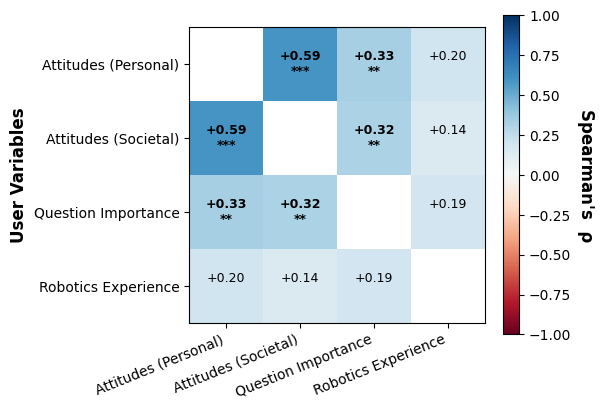

In [16]:
# --------------------------------------------------
# 1 .  Assemble an r-matrix & matching Holm p-matrix
# --------------------------------------------------
vars_order = ["AttitudesAvgP", "AttitudesAvgS",
              "Average_Imp", "RobotExpScale"]

# map each label (exact strings from your `labels`) to indices
pair_to_idx = {
    ("AttitudesAvgP", "AttitudesAvgS"): 0,
    ("AttitudesAvgP", "Average_Imp"):   1,
    ("AttitudesAvgS", "Average_Imp"):   2,
    ("RobotExpScale", "Average_Imp"):   3,
    ("RobotExpScale", "AttitudesAvgP"): 4,
    ("RobotExpScale", "AttitudesAvgS"): 5,
}

n = len(vars_order)
R   = np.full((n, n), np.nan)   # correlation coefficients
P_H = np.full((n, n), np.nan)   # Holm-adjusted p-values

for i_label, (lab, r, pH) in enumerate(zip(labels, r_vals, p_holm)):
    left, right = [s.strip() for s in lab.split("  vs  ")]
    i, j = vars_order.index(left), vars_order.index(right)
    R[i, j] = R[j, i] = r
    P_H[i, j] = P_H[j, i] = pH

# --------------------------------------------------
# 2 .  Plot heat-map
# --------------------------------------------------
fig, ax = plt.subplots(figsize=(6, 5))

im = ax.imshow(R, vmin=-1, vmax=1)         # default colormap; no colours set explicitly

# tick labels
ax.set_xticks(range(n), vars_order, rotation=45, ha="right")
ax.set_yticks(range(n), vars_order)

# --------------------------------------------------
# 3 .  Annotate cells with r & significance stars
# --------------------------------------------------
for i in range(n):
    for j in range(n):
        if i == j or np.isnan(R[i, j]):   # skip diagonal / empty cells
            continue
        r = R[i, j]
        p = P_H[i, j]

        # choose star(s) for Holm-corrected p
        if   p < 0.001: stars = "***"
        elif p < 0.01:  stars = "**"
        elif p < 0.05:  stars = "*"
        else:           stars = ""

        ax.text(j, i, f"{r:+.2f}\n{stars}",
                ha="center", va="center",
                fontsize=9, fontweight="bold" if stars else "normal")
        
im = ax.imshow(
        R,
        vmin=-1, vmax=1,
        cmap="RdBu"      # e.g. "coolwarm", "RdBu", "seismic"
        )
cbar = fig.colorbar(im, ax=ax, shrink=0.8) 
# bold
cbar.ax.set_ylabel("Spearman's  ρ", rotation=-90, va="bottom", fontsize=12, fontweight="bold")

# replace labels (dictionary)

replacement_dict = {
    "AttitudesAvgP": "Attitudes (Personal)",
    "AttitudesAvgS": "Attitudes (Societal)",
    "Average_Imp": "Question Importance",
    "RobotExpScale": "Robotics Experience"
}

vars_order = [replacement_dict.get(var, var) for var in vars_order]
ax.set_xticklabels(vars_order, rotation=22, ha="right")
ax.set_yticklabels(vars_order)
#ax.set_title("Pearson Correlations & Holm-Corrected p-values", fontsize=14, fontweight="bold")
#ax.set_xlabel("Variables", fontsize=12)
ax.set_ylabel("User Variables", fontsize=12, fontweight="bold")

plt.tight_layout()
plt.show()

# save as pdf
fig.savefig(os.path.join(os.getcwd(), 'plots/pearson_correlations.pdf'), format='pdf', bbox_inches='tight')


In [17]:
def compare_group_distribution(
    df_annotated: pd.DataFrame,
    df_participants: pd.DataFrame,
    split_col: str,
    threshold: float = 3.5,
    participant_col_annotated: str = "Participant_ID",
    participant_col_filtered: str = "Participant_ID",
    group_col: str = "Group",
    plot: bool = True,
):
    """
    Participant-normalized analysis.

    For each participant, compute the proportion of their samples (within their bin)
    that fall into each `group_col` category. Then:
      - Average those participant-level proportions within bin ("low"/"high"),
      - Compare low vs high using Welch's t-test per category.

    Prints t-test results and returns a dict with tables and stats.
    """

    # ---------- pick only needed cols and CAST the split column to float ----------
    fil = df_participants[[participant_col_filtered, split_col]].copy()
    fil[participant_col_filtered] = fil[participant_col_filtered].astype(str).str.strip()
    fil[split_col] = pd.to_numeric(fil[split_col], errors="coerce")  # force float
    fil = fil.drop_duplicates(subset=[participant_col_filtered])

    # ---------- prepare annotated and merge on participant id ----------
    ann = df_annotated.copy()
    ann[participant_col_annotated] = ann[participant_col_annotated].astype(str).str.strip()

    merged = ann.merge(
        fil,
        left_on=participant_col_annotated,
        right_on=participant_col_filtered,
        how="inner",
        validate="m:1",
    )

    # drop rows with missing category (important for proper denominators)
    merged = merged.dropna(subset=[group_col])

    # ---------- make bins: high if >= threshold, else low ----------
    bins = np.where(merged[split_col] >= threshold, "high", "low")
    merged = merged.assign(bin=pd.Categorical(bins, categories=["low","high"]))

    pid = participant_col_filtered  # participant id present post-merge
    merged[group_col] = merged[group_col].astype("category")
    categories = list(merged[group_col].cat.categories)

    # ---------- participant-level category proportions ----------
    # counts per participant x bin x category
    per_part = (
        merged.groupby([pid, "bin", group_col], observed=False)
              .size()
              .rename("n")
              .reset_index()
    )
    totals = (
        per_part.groupby([pid, "bin"], observed=False)["n"]
                .sum()
                .rename("N")
                .reset_index()
    )
    per_part = per_part.merge(totals, on=[pid, "bin"], how="left")
    per_part["prop"] = per_part["n"] / per_part["N"]

    # ensure zero-proportions exist for categories a participant didn't produce
    participants = merged[[pid, "bin"]].drop_duplicates()
    cats_df = pd.DataFrame({group_col: categories})
    participants["key"] = 1
    cats_df["key"] = 1
    full = participants.merge(cats_df, on="key").drop(columns="key")

    per_part_full = full.merge(
        per_part[[pid, "bin", group_col, "prop"]],
        on=[pid, "bin", group_col],
        how="left"
    )
    per_part_full["prop"] = per_part_full["prop"].fillna(0.0)

    # mean participant-level proportion per category x bin
    prop_tbl = (
        per_part_full.groupby([group_col, "bin"], observed=False)["prop"]
                     .mean()
                     .unstack("bin")
                     .reindex(index=categories, columns=["low","high"])
    )

    # convenience: participant counts per bin
    n_participants_by_bin = participants["bin"].value_counts().reindex(["low","high"]).fillna(0).astype(int)

    # ---------- Q_Importance: participant-level means ----------
    qcol = "Q_Importance"
    mean_tbl = None
    n_tbl = None
    if qcol in merged.columns:
        merged[qcol] = pd.to_numeric(merged[qcol], errors="coerce")
        # participant-level mean first
        pii = (merged.groupby([pid, group_col, "bin"], observed=False)[qcol]
                     .mean()
                     .reset_index())
        # drop participants that are NaN for this measure
        pii = pii.dropna(subset=[qcol])

        mean_tbl = (pii.groupby([group_col, "bin"], observed=False)[qcol]
                       .mean()
                       .unstack("bin")
                       .reindex(index=categories, columns=["low","high"]))
        n_tbl = (pii.groupby([group_col, "bin"], observed=False)[qcol]
                    .size()
                    .unstack("bin")
                    .reindex(index=categories, columns=["low","high"])
                    .fillna(0).astype(int))

        if {"low", "high"}.issubset(mean_tbl.columns):
            mean_tbl["Δ (high - low)"] = mean_tbl["high"] - mean_tbl["low"]

        print("Average participant-level Q_Importance by group and bin:")
        print(mean_tbl.round(3).to_string())
        print("\nParticipant counts (n) contributing Q_Importance per group × bin:")
        print(n_tbl.to_string())

    # ---------- Welch t-tests: low vs high on participant proportions per category ----------
    rows = []
    for c in categories:
        low_vec  = per_part_full.loc[(per_part_full["bin"] == "low")  & (per_part_full[group_col] == c), "prop"].values
        high_vec = per_part_full.loc[(per_part_full["bin"] == "high") & (per_part_full[group_col] == c), "prop"].values

        # ttest_ind returns (t, p, df). Use Welch ('unequal') to avoid equal-variance assumption.
        t_stat, p_val, df_welch = ttest_ind(high_vec, low_vec, alternative="two-sided", usevar="unequal")

        rows.append({
            group_col: c,
            "n_low":  len(low_vec),
            "n_high": len(high_vec),
            "mean_low":  float(np.mean(low_vec))  if len(low_vec)  else np.nan,
            "mean_high": float(np.mean(high_vec)) if len(high_vec) else np.nan,
            "Δ (high - low)": (float(np.mean(high_vec)) - float(np.mean(low_vec))) if (len(low_vec) and len(high_vec)) else np.nan,
            "t": float(t_stat),
            "df": float(df_welch),
            "p_two_sided": float(p_val),
        })

    ttest_df = pd.DataFrame(rows).set_index(group_col).loc[categories]

    print("\nParticipant-normalized proportions by group (%):")
    print((prop_tbl * 100).round(1).to_string())

    print("\nWelch t-tests (per category): high vs. low on participant-level proportions")
    print(ttest_df.round(4).to_string())

    # ---------- Plot ----------
    if plot and not prop_tbl.empty:
        categories_list = list(prop_tbl.index)
        low_vals  = (prop_tbl["low"]  * 100.0).values if "low"  in prop_tbl.columns else np.zeros(len(categories_list))
        high_vals = (prop_tbl["high"] * 100.0).values if "high" in prop_tbl.columns else np.zeros(len(categories_list))

        fig = go.Figure()
        width = 0.40

        fig.add_trace(go.Bar(
            x=categories_list,
            y=low_vals,
            name=f"low robot experience (< {threshold})",
            offsetgroup=0,
            width=width
        ))

        fig.add_trace(go.Bar(
            x=categories_list,
            y=high_vals,
            name=f"high robot experience (≥ {threshold})",
            offsetgroup=1,
            width=width
        ))

        fig.update_layout(
            barmode="group",
            xaxis=dict(tickmode="array", tickvals=categories_list, tickangle=-30),
            yaxis_title="Category Distribution (%)",
            title=None,
            legend_title_text="Threshold",
            width=1000,
            height=500,
            # move legend inside figure
            legend=dict(x=0.7, y=1, orientation="v"),
        )
        fig.show()

        # save to pdf (optional)
        try:
            os.makedirs("plots", exist_ok=True)
            fig.write_image(
                f"plots/Category_differency_by_{split_col}_participant_normalized.pdf",
                format="pdf", width=1000, height=500
            )
        except Exception as e:
            print(f"[write_image skipped] {e}")

    return {
        # participant-normalized distribution
        "participant_prop_mean_by_group_bin": prop_tbl,              # mean proportion per category × bin
        "participant_prop_percent_by_bin": (prop_tbl * 100.0),       # same, in %
        "n_participants_by_bin": n_participants_by_bin,              # participants per bin

        # per-category Welch t-tests comparing high vs low on participant proportions
        "ttest_by_category": ttest_df,                               # columns: n_low, n_high, mean_low, mean_high, Δ, t, df, p

        # Q_Importance at participant level (if present)
        "q_importance_mean_by_group_bin": mean_tbl,
        "q_importance_n_by_group_bin": n_tbl,

        # housekeeping
        "merge_n_rows": len(merged),
        "unique_participants": participants[pid].nunique(),
    }

res_robot = compare_group_distribution(
    df_annotated, df_participants,
    split_col="RobotExpScale",
    threshold=3.5,
    plot=True
)


Average participant-level Q_Importance by group and bin:
bin                     low   high  Δ (high - low)
Group                                             
environment-state     3.756  3.955           0.198
execution-details     3.742  3.918           0.176
future-actions        3.557  3.556          -0.002
how-did-you-decide    3.773  4.060           0.287
how-did-you-know      4.008  4.266           0.258
mental-state          3.538  3.755           0.217
potential-issues      4.132  4.361           0.229
self/task-assessment  3.703  3.961           0.258
technical-details     3.766  4.167           0.401
time                  3.558  3.712           0.154
what-abilities        3.527  3.765           0.238
why                   3.423  3.864           0.441

Participant counts (n) contributing Q_Importance per group × bin:
bin                   low  high
Group                          
environment-state      45    11
execution-details      68    22
future-actions         29    12
ho

# Syntax Statistics

In [ ]:
# --------------------------------------------------------------------------- #
#  spaCy model                                                                #
# --------------------------------------------------------------------------- #
MODEL = "en_core_web_sm"
if not is_package(MODEL):
    download(MODEL)
nlp = spacy.load(MODEL)

# --------------------------------------------------------------------------- #
#  Static resources                                                           #
# --------------------------------------------------------------------------- #
_PRONOUN_TO_PERSON = {
    **{w: "1st" for w in
       ["i", "me", "we", "us", "my", "our", "mine", "ours"]},
    **{w: "2nd" for w in
       ["you", "your", "yours"]},
    **{w: "3rd" for w in
       ["he", "she", "it", "they", "him", "her", "them",
        "his", "hers", "its", "their", "theirs"]},
}
_MODAL_PRESENT = {"can", "could", "may", "might", "must", "should", "would", "ought"}

def _pronoun_person(txt: str) -> str | None:
    return _PRONOUN_TO_PERSON.get(txt.lower())

# --------------------------------------------------------------------------- #
#  Predicate & subject helpers                                                #
# --------------------------------------------------------------------------- #
def _find_main_predicate(doc):
    verb = doc[-1].sent.root
    while verb.dep_ in {"aux", "auxpass"} and verb.head is not verb:
        verb = verb.head
    return verb if verb.pos_ in {"VERB", "AUX"} else None

def _find_subject(verb):
    subj_deps = {"nsubj", "nsubjpass", "csubj", "csubjpass"}
    for child in verb.children:
        if child.dep_ in subj_deps:
            return child
    for anc in verb.ancestors:
        for child in anc.children:
            if child.dep_ in subj_deps:
                return child
    for child in verb.children:            # existential/copular
        if child.dep_ == "attr":
            return child
    return None

# --------------------------------------------------------------------------- #
#  Tense · Voice · Person                                                     #
# --------------------------------------------------------------------------- #
def _classify_tense(verb) -> str:
    """
    Past / Present / Future / Unknown

    Strategy (stop at first match):
        1. Verb's own morphological Tense
        2. Verb's POS-tag
        3. Auxiliaries (children + ancestors)
    """
    # 1) Morph features on the lexical verb
    if verb.morph.get("Tense"):
        return "Past" if verb.morph.get("Tense")[0] == "Past" else "Present"

    # 2) POS tag on the lexical verb
    if verb.tag_ in {"VBD", "VBN"}:
        return "Past"
    if verb.tag_ in {"VBZ", "VBP"}:
        return "Present"

    # 3) Search auxiliaries for tense cues
    aux_tokens = [tok for tok in verb.children if tok.dep_ in {"aux", "auxpass"}]
    aux_tokens += [tok for tok in verb.ancestors if tok.dep_ in {"aux", "auxpass"}]

    for aux in aux_tokens:
        # strict morphological match
        if aux.morph.get("Tense") == ["Past"] or aux.tag_ == "VBD":
            return "Past"
        if aux.lower_ in {"will", "shall", "'ll"}:
            return "Future"
        if aux.morph.get("Tense") == ["Pres"]:
            return "Present"
        if aux.lower_ in _MODAL_PRESENT:
            return "Present"

    # lexical future fallback (“will” as main verb)
    if verb.lower_ in {"will", "shall", "'ll"}:
        return "Future"

    return "Unknown"

def _classify_voice(verb) -> str:
    if verb.morph.get("Voice") == ["Pass"]:
        return "Passive"
    if any(c.dep_ == "nsubjpass" for c in verb.children) or verb.dep_ == "auxpass":
        return "Passive"
    return "Active"

def _classify_person(subj, verb) -> str:
    if subj:
        p = _pronoun_person(subj.text)
        if p:
            return p
        if subj.morph.get("Person"):
            return {"1": "1st", "2": "2nd", "3": "3rd"}.get(
                subj.morph.get("Person")[0], "Unknown")
        return "3rd"
    if verb.morph.get("Mood") == "Imp" or (verb.tag_ == "VB" and verb.dep_ == "ROOT"):
        return "2nd"   # implicit YOU
    return "Unknown"

# --------------------------------------------------------------------------- #
#  Core analyser                                                              #
# --------------------------------------------------------------------------- #
def analyse_sentences(sentences: list[str]) -> dict:
    make = lambda: defaultdict(lambda: {"count": 0, "sentences": []})
    tense_b, voice_b, person_b = make(), make(), make()

    for sent in sentences:
        doc  = nlp(sent)
        verb = _find_main_predicate(doc)
        if not verb:
            continue

        subj   = _find_subject(verb)
        tense  = _classify_tense(verb)
        voice  = _classify_voice(verb)
        person = _classify_person(subj, verb)

        for bucket, label in ((tense_b, tense), (voice_b, voice), (person_b, person)):
            bucket[label]["count"] += 1
            bucket[label]["sentences"].append(sent)

    return {"tense": dict(tense_b), "voice": dict(voice_b), "person": dict(person_b)}

# --------------------------------------------------------------------------- #
#  Pretty print                                                               #
# --------------------------------------------------------------------------- #
def _print_section(title: str, data: dict, show_examples: bool):
    total = sum(v["count"] for v in data.values()) or 1
    print(f"{title} distribution:")
    for label in sorted(data):
        v   = data[label]
        pct = v["count"] / total
        print(f"  {label:<8}: {v['count']:3} ({pct:5.1%})")
        if show_examples:
            for s in v["sentences"]:
                print(f"        ↳ {s}")
    print()

def print_stats(results: dict, show_examples: bool = False):
    _print_section("Tense",  results["tense"],  show_examples)
    _print_section("Voice",  results["voice"],  show_examples)
    _print_section("Person", results["person"], show_examples)

stats = analyse_sentences(df_annotated["Question"][df_annotated["Group"] != "excluded"].tolist())
print_stats(stats)

# print average sentence lenght with SD
avg_length = df_annotated["Question"][df_annotated["Group"] != "excluded"].str.split().apply(len).mean()
std_length = df_annotated["Question"][df_annotated["Group"] != "excluded"].str.split().apply(len).std()
# average number of questions per participant
avg_questions_per_participant = df_annotated.groupby('Participant_ID').size().mean()
std_questions_per_participant = df_annotated.groupby('Participant_ID').size().std()
print(f"Average number of questions per participant: {avg_questions_per_participant:.2f}, (SD = {std_questions_per_participant:.2f})")
print(f"Average sentence length: {avg_length:.2f} words (SD = {std_length:.2f})")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 7.8 MB/s  0:00:01m0:00:0100:01
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.
Tense distribution:
  Future  :  32 ( 1.7%)
  Past    : 939 (49.2%)
  Present : 916 (48.0%)
  Unknown :  20 ( 1.0%)

Voice distribution:
  Active  : 1866 (97.9%)
  Passive :  41 ( 2.1%)

Person distribution:
  1st     :  44 ( 2.3%)
  2nd     : 1278 (67.0%)
  3rd     : 570 (29.9%)
  Unknown :  15 ( 0.8%)

Average number of questions per participant: 19.48, (SD = 3.13)
Average sentence length: 9.87 words (SD = 4.35)


In [19]:
stats["person"]["3rd"]["sentences"][:10]

['is the salad allergy friendly?',
 'Did the robot follow a particular recipe?',
 'how long will it take to finish the salad',
 'How many calories is the salad?',
 'How does it know how much to take?',
 'Can other ingredients be added to the salad, or is there a limit to steps?',
 'was it easy to pick up the ingredients and mix them',
 'What were the proportions of the things put into salad?',
 'Was it able to identify the components independently?',
 'what was in the salad']